In [1]:
import tensorflow as tf
from tensorflow.keras.applications import (ResNet50, VGG16, imagenet_utils)
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Plot Images

In [2]:
def plot_images(image, cam):
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(cam, cmap='jet')
    plt.show()
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.show()

In [3]:
def get_image(image_path):
    orig = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(orig)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    return image, orig

In [4]:
def get_model(architecture='vgg'):
    Model = ResNet50 if architecture == 'resnet' else VGG16
    return Model(weights='imagenet')

In [5]:
def get_prediction(model):
    preds = model.predict(image)
    class_idx = np.argmax(preds[0])
    decoded = imagenet_utils.decode_predictions(preds)
    (imagenetID, label, prob) = decoded[0][0]
    return (imagenetID, label, prob, class_idx)

In [6]:
model = get_model(architecture='resnet')
image, orig = get_image('Images/sample_image.jpg')
imagenetID, label, prob, class_idx = get_prediction(model=model)

### CAM Implementation: 
> <b>Network architecture should have CONV -> Global Avg Pooling -> Outputs</b>

In [7]:
class CAM:
    def __init__(self, model, layer_name=None):
        self.model=model
        self.layer_name=layer_name
        if not layer_name:
            self.layer_name = self.find_target_layer()
    
    def compute_cam_features(self, image):
        cam_model = tf.keras.models.Model(inputs=[self.model.inputs],
                                           outputs=[self.model.get_layer(self.layer_name).output, self.model.output])
        features, outputs = cam_model.predict(image)
        global_avg_pool_weights = self.model.layers[-1].get_weights()[0]
        image_feature = features[0]
        cam_features = resize(image_feature, (224,224))
        pred = np.argmax(outputs[0])
        cam_weights = global_avg_pool_weights[:,pred]
        cam_output  = np.dot(cam_features,cam_weights)
        return cam_output

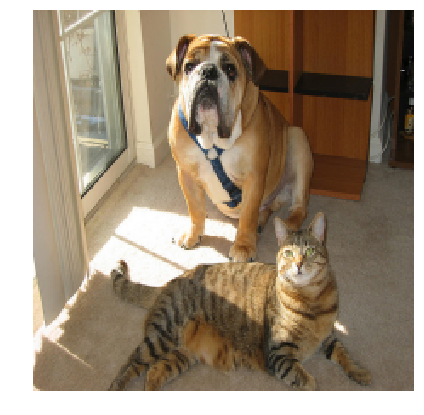

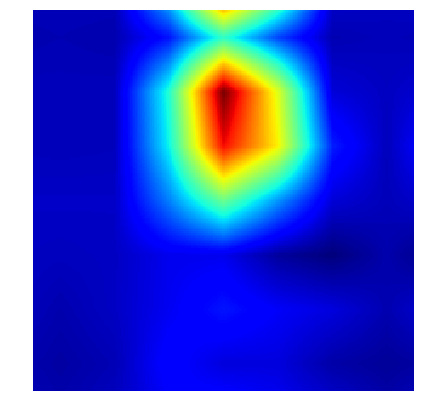

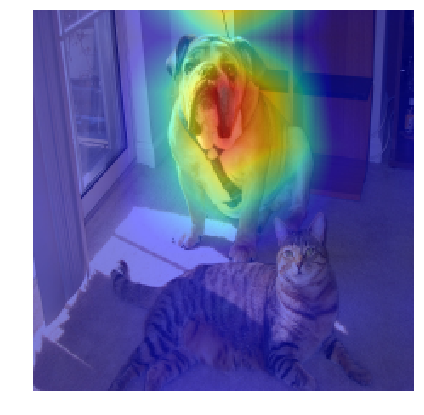

In [8]:
# Eg for resnet only
cam = CAM(model, layer_name='conv5_block3_out')
cam_features = cam.compute_cam_features(image)
plot_images(orig, cam_features)

### Grad-CAM Implementation
* class_idx: Parameter containing index of the class for which we want to see the porition of features resulting for that class.
* layer_name: Parameter containing the string layer name on which we want to see feature maps.

In [9]:
class GradCAM:
    
    def __init__(self, model, class_idx, layer_name=None):
        self.model=model
        self.class_idx=class_idx
        self.layer_name=layer_name
        if not layer_name:
            self.layer_name = self.find_target_layer()
        
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError('Could not find 4D layer. Cannot apply GradCAM.')

    def compute_cam(self, image, eps=1e-8):
        grad_model = tf.keras.models.Model(inputs=[self.model.inputs],
                                           outputs=[self.model.get_layer(self.layer_name).output, self.model.output])
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            conv_outs, predictions = grad_model(inputs)
            y_c = predictions[:, self.class_idx]

        # compute the gradient of the score for the class c, with respect to feature maps Ak of a convolutional layer
        grads = tape.gradient(y_c, conv_outs) 
        # compute the guided gradients Basically applying ReLU
        cast_conv_outputs = tf.cast(conv_outs > 0, tf.float32)
        cast_grads = tf.cast(grads > 0, tf.float32)
        # guided_grads = where conv_out and their gradients are both positive numbers
        guided_grads = cast_conv_outputs * cast_grads * grads 
        
        conv_outs = conv_outs[0]
        guided_grads = guided_grads[0]
        
        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with
        # respect to the weights (Global pooling average)
        weights = tf.reduce_mean(guided_grads, axis=(0, 1))
        
        # After calculating ak for the target class c, we perform a weighted combination of activation maps.
        cam = tf.reduce_sum(tf.multiply(weights, conv_outs), axis=-1)
        
        w, h = image.shape[2], image.shape[1] 
        cam = resize(cam.numpy(), (w, h))
        cam /= np.max(cam)
        cam = (cam * 255).astype("uint8")
        return cam

In [10]:
class_index = {'tiger_cat': 282, 'beagle': 162}

* <b>Check for Cat(tiger_cat)</b>

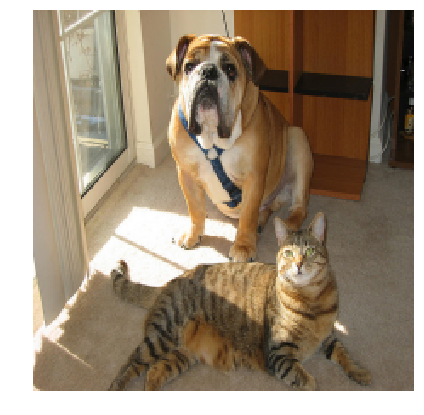

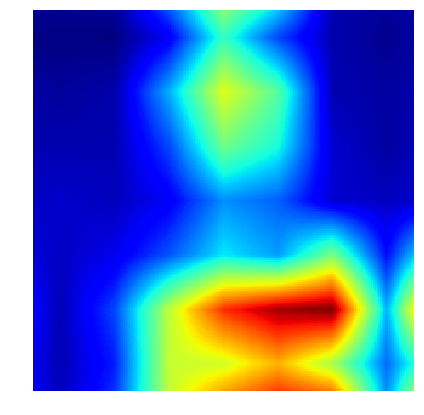

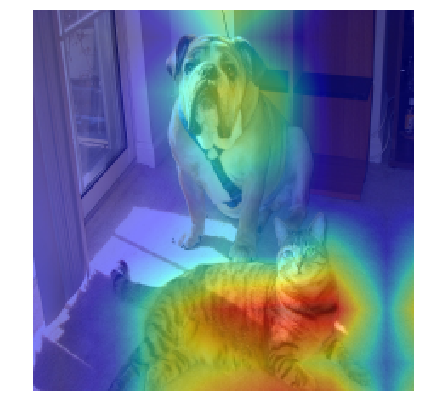

In [11]:
grad_cam = GradCAM(model, class_index['tiger_cat'])
grad_heatmap = grad_cam.compute_heatmap(image)
plot_images(orig, grad_heatmap)

* <b>Check for Dog(beagle)</b>

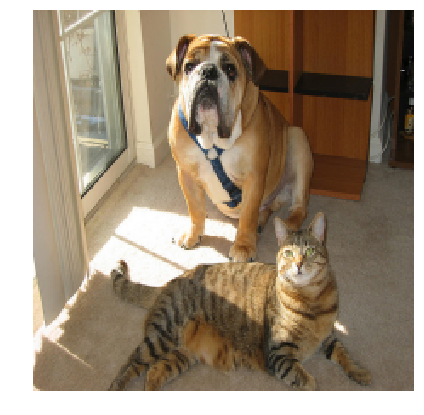

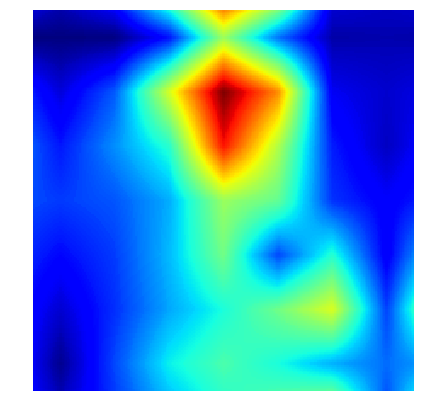

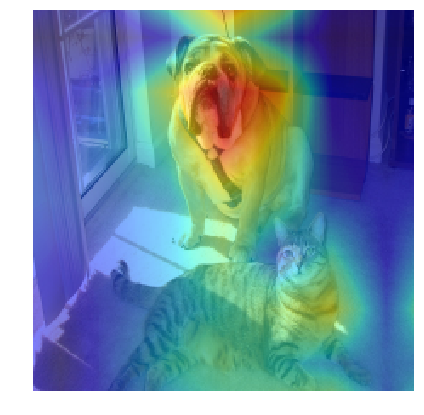

In [12]:
grad_cam = GradCAM(model, class_index['beagle'])
grad_heatmap = grad_cam.compute_cam(image)
plot_images(orig, grad_heatmap)

### Grad-CAM ++ Implementation
<b>* Grad-CAM ++ is modified version on Grad CAM which is helpful to identify smaller objects(class of interest) within the same image</b>
* class_idx: Parameter containing index of the class for which we want to see the porition of features resulting for that class.
* layer_name: Parameter containing the string layer name on which we want to see feature maps.

In [13]:
class GradCAMPlusPlus:
    
    def __init__(self, model, class_idx, layer_name=None):
        self.model=model
        self.class_idx=class_idx
        self.layer_name=layer_name
        if not layer_name:
            self.layer_name = self.find_target_layer()
        
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError('Could not find 4D layer. Cannot apply GradCAMPlusPlus.')

    def compute_cam(self, image, eps=1e-8):
        # Step 4 we find the gradients of the target class score yc with respect to the feature maps Ak
        # of the last convolutional layer
        grad_model = tf.keras.models.Model(inputs=[self.model.inputs],
                                           outputs=[self.model.get_layer(self.layer_name).output, self.model.output])
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            conv_outs, predictions = grad_model(inputs) 
            y_c = predictions[:, self.class_idx]

        # compute the gradient of the score for the class c, with respect to feature maps Ak of a convolutional layer
        batch_grads = tape.gradient(y_c, conv_outs) 
        grads = batch_grads[0]
        first = tf.exp(y_c) * grads
        second = tf.exp(y_c) * tf.pow(grads, 2)
        third = tf.exp(y_c) * tf.pow(grads, 3)
        
        global_sum = tf.reduce_sum(tf.reshape(conv_outs[0], shape=(-1, first.shape[2])), axis=0)
        alpha_num = second
        alpha_denom = second * 2.0 + third * tf.reshape(global_sum, shape=(1,1,first.shape[2]))
        alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones(shape=alpha_denom.shape))
        alphas = alpha_num / alpha_denom
        weights = tf.maximum(first, 0.0)
        alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas, axis=0), axis=0)
        alphas /= tf.reshape(alpha_normalization_constant, shape=(1,1,first.shape[2]))
        alphas_thresholding = np.where(weights, alphas, 0.0)

        alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas_thresholding, axis=0),axis=0)
        alpha_normalization_constant_processed = tf.where(alpha_normalization_constant != 0.0, alpha_normalization_constant,
                                                          tf.ones(alpha_normalization_constant.shape))

        alphas /= tf.reshape(alpha_normalization_constant_processed, shape=(1,1,first.shape[2]))
        deep_linearization_weights = tf.reduce_sum(tf.reshape((weights*alphas), shape=(-1,first.shape[2])), axis=0)
        grad_CAM_map = tf.reduce_sum(deep_linearization_weights * conv_outs[0], axis=2)
        cam = np.maximum(grad_CAM_map, 0)
        cam = cam / np.max(cam)  
        cam = resize(cam, (224,224))
        cam = np.maximum(grad_CAM_map, 0)
        cam = cam / np.max(cam)
        cam = resize(cam, (224,224))
        return cam

* <b>Check for cat(tiger_cat)</b>

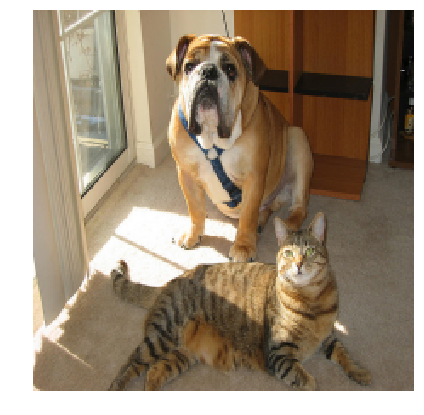

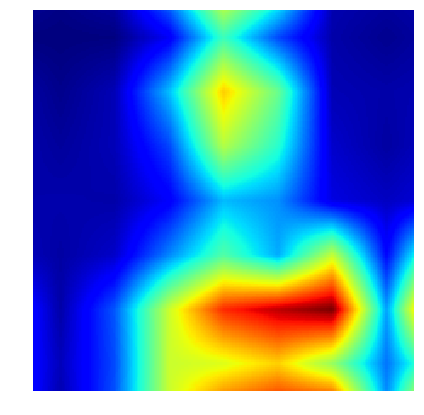

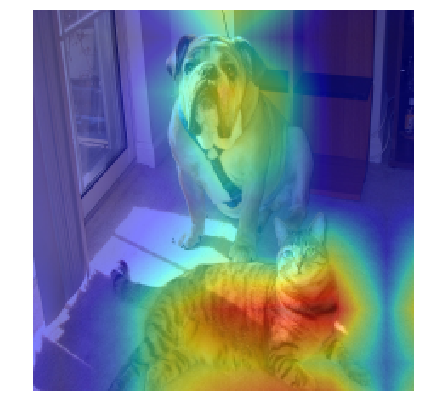

In [14]:
grad_cam_plus_plus = GradCAMPlusPlus(model, class_index['tiger_cat'])
grad_plus_plus_heatmap = grad_cam_plus_plus.compute_cam(image)
plot_images(orig, grad_plus_plus_heatmap)

* <b>Check for Dog(beagle)</b>

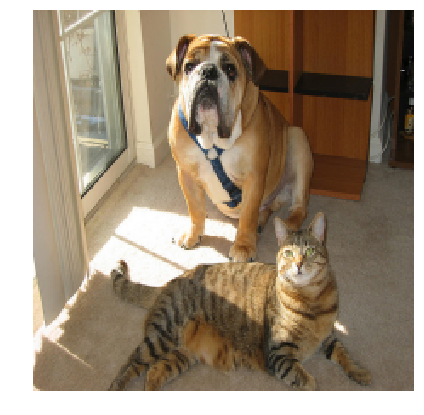

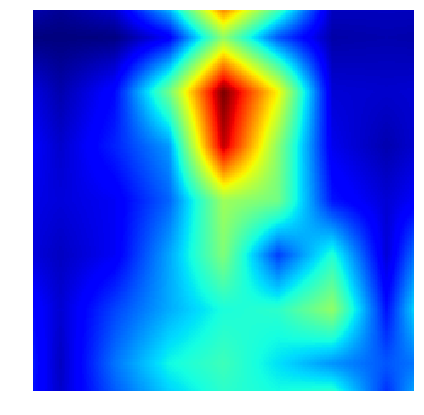

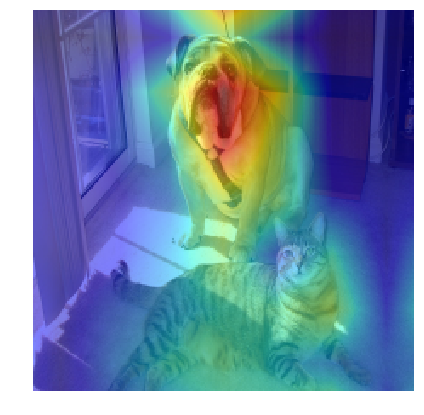

In [15]:
grad_cam_plus_plus = GradCAMPlusPlus(model, class_index['beagle'])
grad_plus_plus_heatmap = grad_cam_plus_plus.compute_heatmap(image)
plot_images(orig, grad_plus_plus_heatmap)